# OPSD Model Diagnostics

Loads the best checkpoint and produces forecast plots + error diagnostics.

> Requires `checkpoints/opsd_best.pt` produced by training.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

REPO_ROOT = (
    os.path.abspath(os.path.join(os.getcwd(), ".."))
    if os.path.basename(os.getcwd()) == "notebooks"
    else os.getcwd()
)
SRC_DIR = os.path.join(REPO_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import torch
from torch.utils.data import DataLoader

from data.sqlite_opsd import load_opsd_sqlite
from data.preprocess import (
    enforce_hourly_index,
    impute_median_ffill_bfill,
    time_split_indices,
    make_arrays_and_scalers,
    add_calendar_features,
    add_lag_features,
    drop_initial_rows_for_lags,
)
from data.window_dataset import WindowDataset
from models.lstm import LSTMForecaster
from evaluate import predict  # returns arrays
from baselines import seasonal_naive_windows
from metrics import mae, rmse, smape

plt.rcParams["figure.figsize"] = (12, 4)

## Load config and rebuild the exact pipeline

In [4]:
import yaml

CONFIG_PATH = os.path.join(REPO_ROOT, "configs", "opsd_lstm.yaml")
with open(CONFIG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

SQLITE_PATH = os.path.join(REPO_ROOT, cfg["opsd"]["sqlite_path"])
TABLE = cfg["opsd"]["table"]
TS_COL = cfg["opsd"]["timestamp_col"]
TARGET = cfg["opsd"]["target"]
FEATURES = cfg["opsd"]["features"]

CKPT_PATH = os.path.join(REPO_ROOT, cfg["output"]["checkpoints_dir"], cfg["output"]["best_name"])
device = "cuda" if torch.cuda.is_available() else "cpu"

df = load_opsd_sqlite(
    sqlite_path=SQLITE_PATH,
    table=TABLE,
    timestamp_col=TS_COL,
    columns=list(dict.fromkeys(FEATURES + [TARGET])),
    start_utc=cfg["opsd"].get("start_utc"),
    end_utc=cfg["opsd"].get("end_utc"),
)

if cfg["preprocess"]["enforce_hourly_grid"]:
    df = enforce_hourly_index(df, TS_COL)

df = impute_median_ffill_bfill(df, list(dict.fromkeys(FEATURES + [TARGET])))

# raw for baseline recon
y_raw0 = df[TARGET].to_numpy(dtype=np.float64)

extra_feats = []
if cfg["preprocess"].get("calendar_features", False):
    df, cal_cols = add_calendar_features(df, TS_COL)
    extra_feats.extend(cal_cols)

lags = cfg["preprocess"].get("lags", [])
if lags:
    df, lag_cols = add_lag_features(df, TARGET, lags)
    extra_feats.extend(lag_cols)
    df = drop_initial_rows_for_lags(df, lags)

FEATURES2 = FEATURES + extra_feats
y_raw = df[TARGET].to_numpy(dtype=np.float64)

# residual target
target_used = TARGET
mode = cfg["preprocess"].get("target_mode", "absolute")
residual_lag = int(cfg["preprocess"].get("residual_lag", 168))
if mode == "residual_over_lag":
    df["_target_residual"] = df[TARGET] - df[f"lag_{residual_lag}"]
    target_used = "_target_residual"

T = len(df)
tr, va, te = time_split_indices(T, cfg["split"]["train"], cfg["split"]["val"])

X_all, y_all, xscaler, yscaler = make_arrays_and_scalers(df, FEATURES2, target_used, tr)

lookback = cfg["window"]["lookback"]
horizon = cfg["window"]["horizon"]

X_te, y_te = X_all[te], y_all[te]
test_ds = WindowDataset(X_te, y_te, lookback, horizon)
test_dl = DataLoader(test_ds, batch_size=cfg["train"]["batch_size"], shuffle=False, num_workers=cfg["train"]["num_workers"])

# baseline windows for reconstruction
test_base = None
if mode == "residual_over_lag":
    _, test_base = seasonal_naive_windows(y_raw, te.start, te.stop, lookback, horizon, season=residual_lag)

# build model and load weights
n_features = X_all.shape[1]
mcfg = cfg["model"]
model = LSTMForecaster(n_features, mcfg["hidden"], mcfg["layers"], mcfg["dropout"], horizon).to(device)
model.load_state_dict(torch.load(CKPT_PATH, map_location=device))
model.eval()

print("Loaded:", os.path.relpath(CKPT_PATH, REPO_ROOT))


Loaded: checkpoints/opsd_best.pt


## Predictions and metrics

In [6]:
y_true, y_pred = predict(model, test_dl, device, yscaler=yscaler, baseline_windows=test_base)

print("TEST metrics:")
print(f"  RMSE: {rmse(y_true, y_pred):.2f}")
print(f"  MAE : {mae(y_true, y_pred):.2f}")
print(f"  sMAPE: {smape(y_true, y_pred):.2f}")


TEST metrics:
  RMSE: 3627.84
  MAE : 2347.32
  sMAPE: 4.56


## Plot a few forecast windows (actual vs predicted)

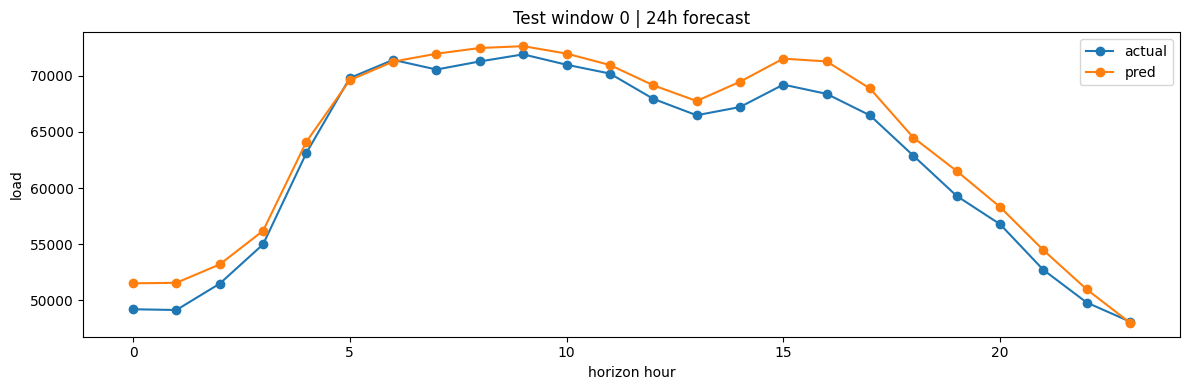

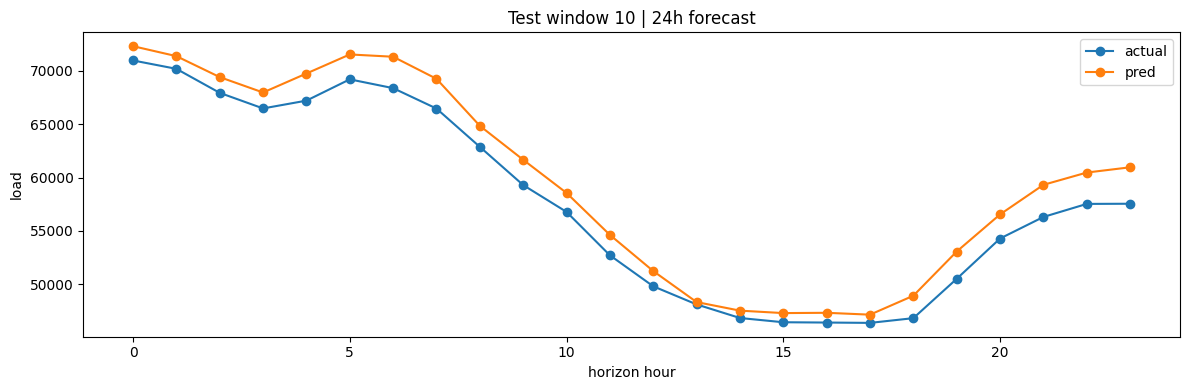

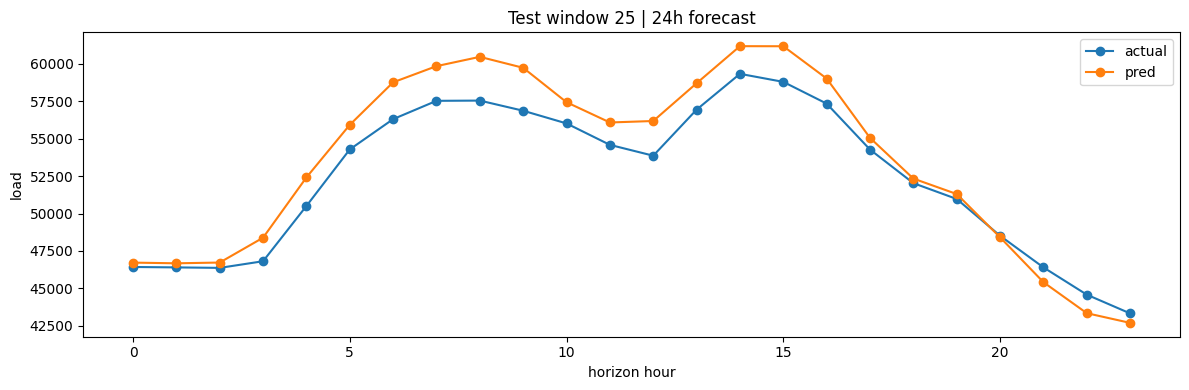

In [7]:
def plot_window(i: int):
    yt = y_true[i]
    yp = y_pred[i]
    plt.figure()
    plt.plot(range(len(yt)), yt, marker="o", label="actual")
    plt.plot(range(len(yp)), yp, marker="o", label="pred")
    plt.title(f"Test window {i} | 24h forecast")
    plt.xlabel("horizon hour")
    plt.ylabel("load")
    plt.legend()
    plt.tight_layout()
    plt.show()

for i in [0, 10, 25]:
    plot_window(i)


## Error diagnostics

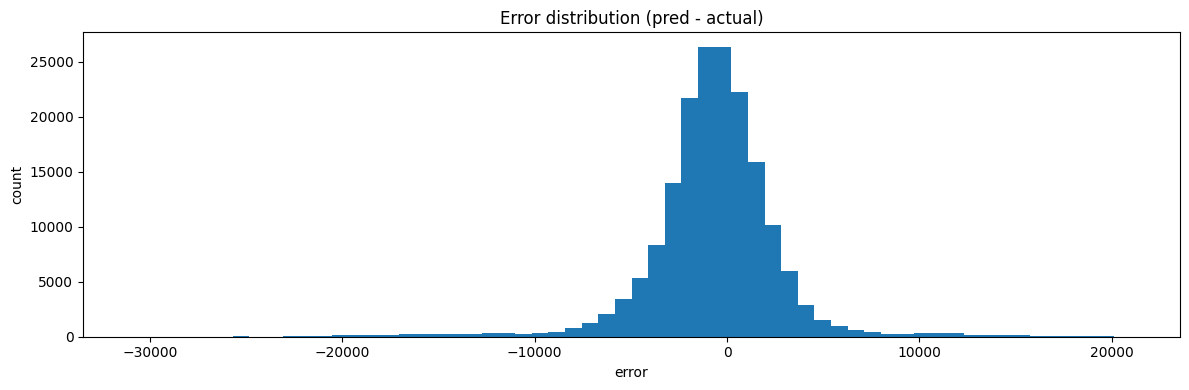

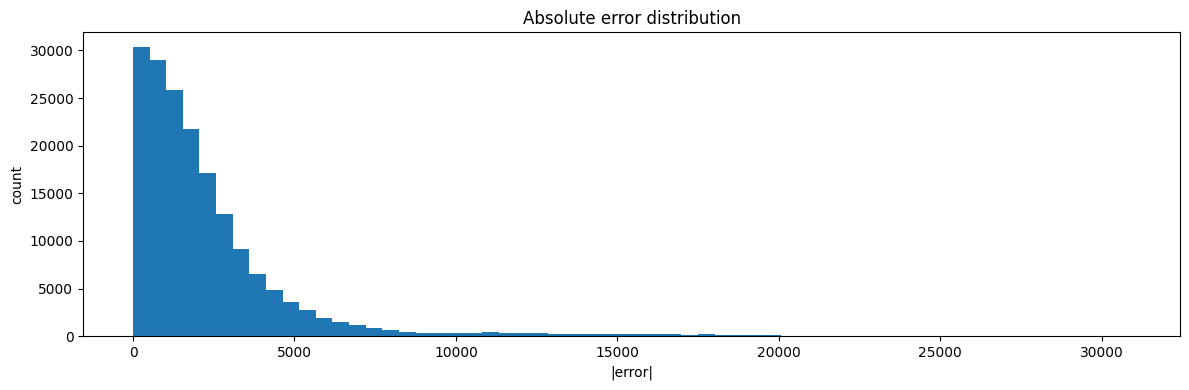

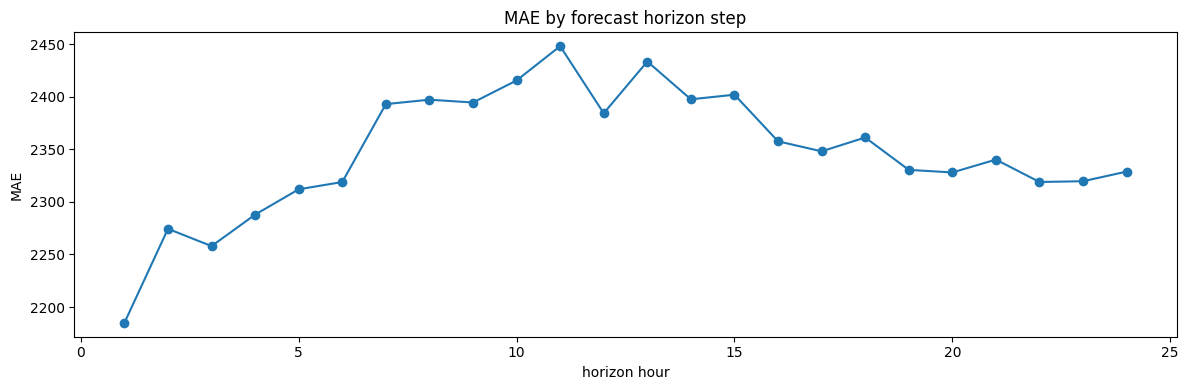

In [8]:
err = (y_pred - y_true)  # shape (N, H)
abs_err = np.abs(err)

plt.figure()
plt.hist(err.ravel(), bins=60)
plt.title("Error distribution (pred - actual)")
plt.xlabel("error")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(abs_err.ravel(), bins=60)
plt.title("Absolute error distribution")
plt.xlabel("|error|")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# MAE per horizon step
mae_by_h = abs_err.mean(axis=0)
plt.figure()
plt.plot(range(1, len(mae_by_h) + 1), mae_by_h, marker="o")
plt.title("MAE by forecast horizon step")
plt.xlabel("horizon hour")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()


## Compare to lag-168 baseline on the same test windows

In [12]:
# Build lag168 baseline windows directly from y_raw (same indexing as te after lags drop)
base_true, base_pred = seasonal_naive_windows(y_raw, te.start, te.stop, lookback, horizon, season=168)

print("Baseline lag168 metrics:")
print(f"  RMSE: {rmse(base_true, base_pred):.2f}")
print(f"  MAE : {mae(base_true, base_pred):.2f}")
print(f"  sMAPE: {smape(base_true, base_pred):.2f}")


Baseline lag168 metrics:
  RMSE: 4163.58
  MAE : 2436.98
  sMAPE: 4.63


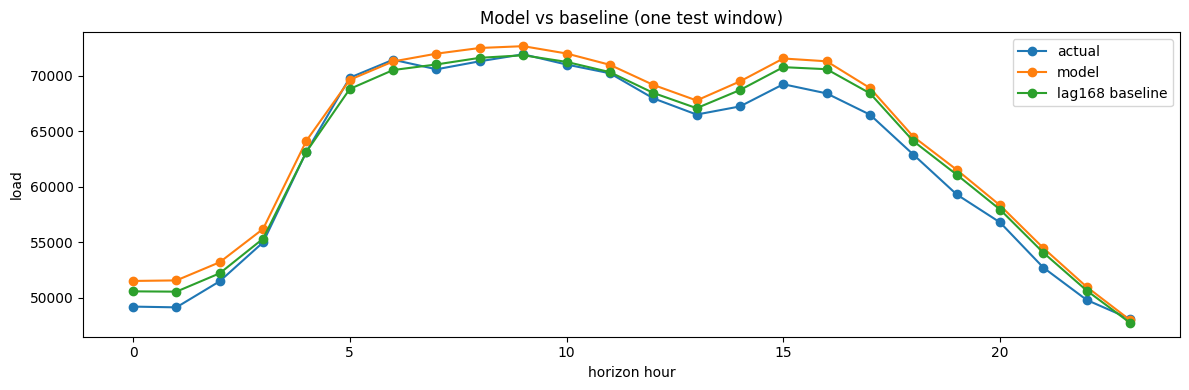

In [13]:
# Side-by-side plot for one window
i = 0
plt.figure()
plt.plot(range(horizon), y_true[i], marker="o", label="actual")
plt.plot(range(horizon), y_pred[i], marker="o", label="model")
plt.plot(range(horizon), base_pred[i], marker="o", label="lag168 baseline")
plt.title("Model vs baseline (one test window)")
plt.xlabel("horizon hour")
plt.ylabel("load")
plt.legend()
plt.tight_layout()
plt.show()
